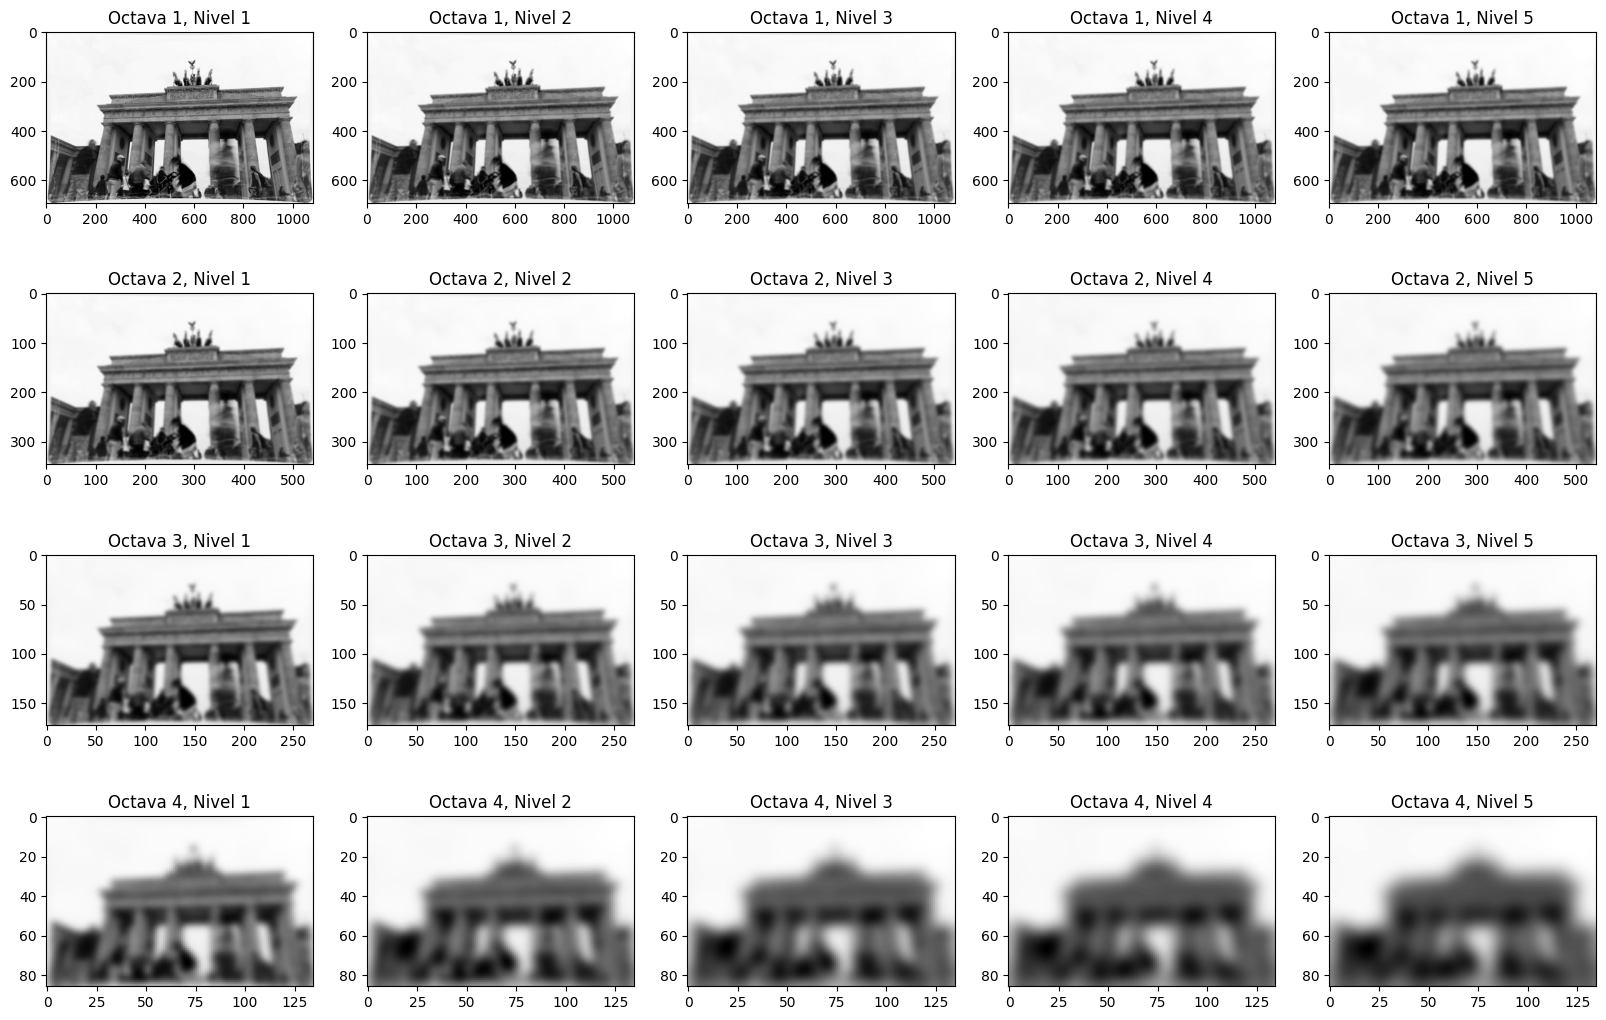

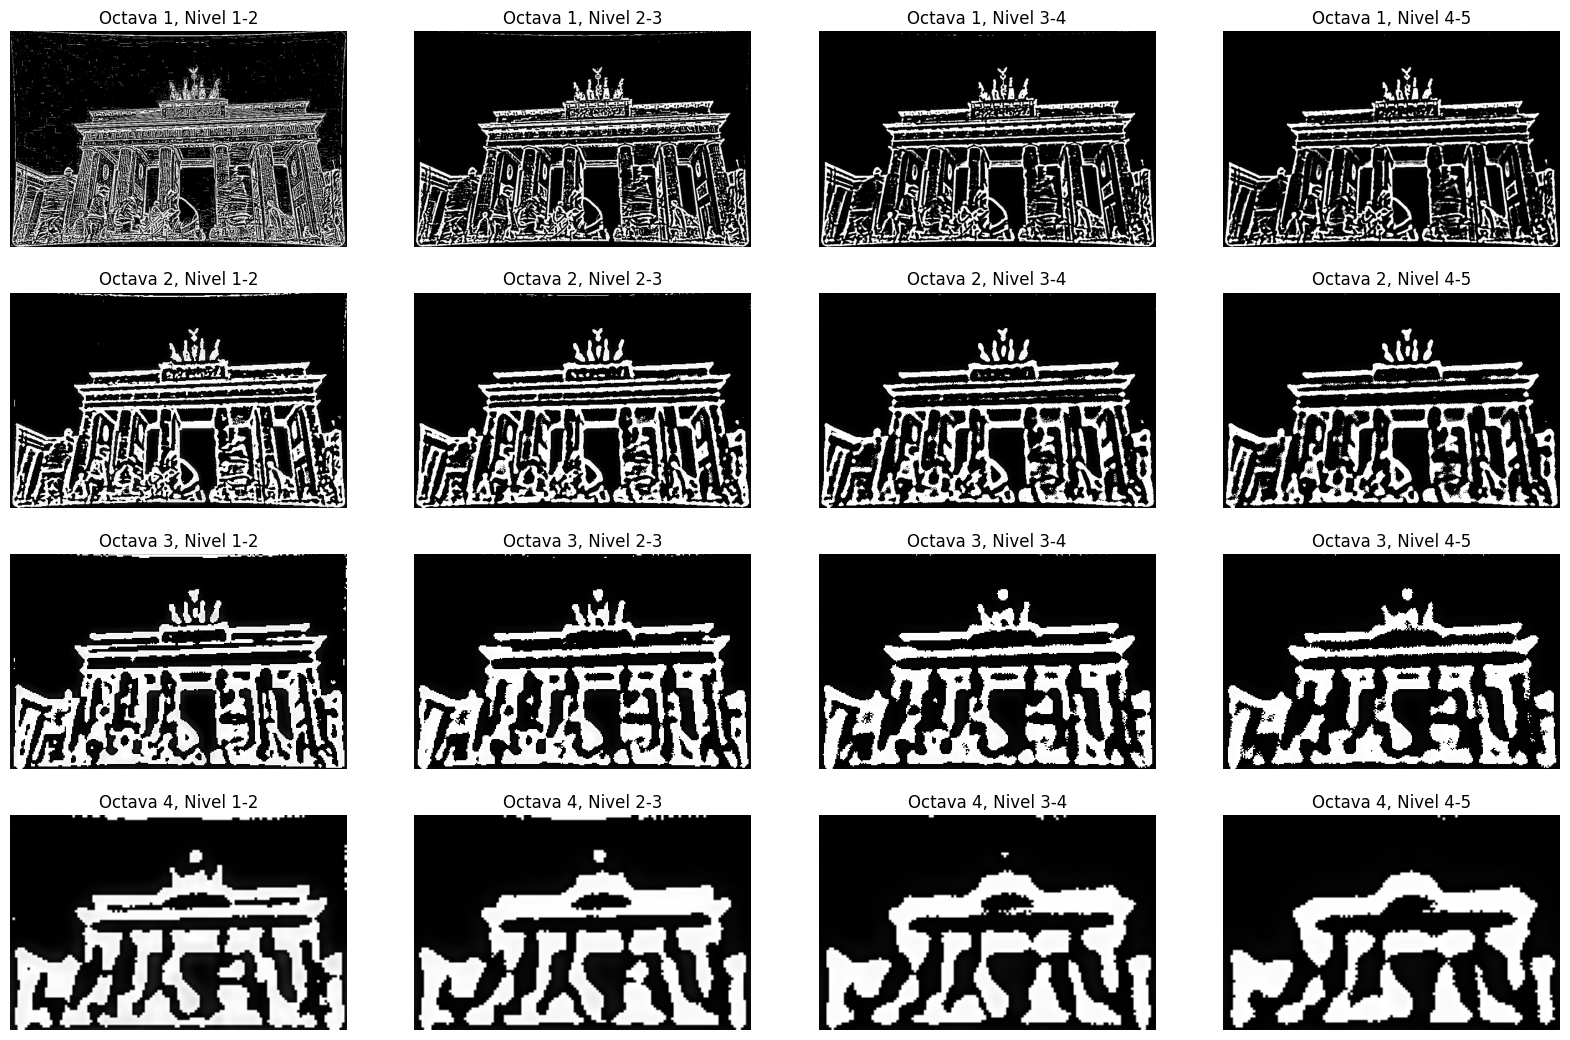

In [21]:
import numpy as np
from scipy.ndimage import convolve
from scipy.ndimage import gaussian_filter
import cv2
from matplotlib import pyplot as plt


def rgb2gray(rgb):
    return np.dot(rgb[..., :3], [0.299, 0.587, 0.114]).astype(np.uint8)

def gaussian_filter(sigma):
	size = 2*np.ceil(3*sigma)+1
	x, y = np.mgrid[-size//2 + 1:size//2 + 1, -size//2 + 1:size//2 + 1]
	g = np.exp(-((x**2 + y**2)/(2.0*sigma**2))) / (2*np.pi*sigma**2)
	return g/g.sum()

def generate_octave(init_level, escalas, sigma):
    octave = [init_level]
    k = 2 ** (1/escalas)
    # Generar el kernel gaussiano
    kernel = gaussian_filter(k * sigma)
    for _ in range(escalas):
        # Convolucionar el nivel anterior con el kernel gaussiano
        next_level = convolve(octave[-1], kernel, mode='nearest')
        octave.append(next_level)
    return octave

def generate_gaussian_pyramid(image, octaves, scales, sigma):
    pyramid = []
    for _ in range(octaves):
        octave = generate_octave(image, scales, sigma)
        pyramid.append(octave)
        # La siguiente imagen de la pirámide es la imagen de nivel 3 de la octava anterior
        image = octave[-3]
        # Reducir la resolución para la siguiente iteración
        image = cv2.resize(image, (image.shape[1] // 2, image.shape[0] // 2), interpolation=cv2.INTER_NEAREST)
    return pyramid


def generate_dog_pyramid(gaussian_pyramid):
    dog_pyramid = []
    for octave in gaussian_pyramid:
        dog_octave = [octave[i] - octave[i+1] for i in range(len(octave) - 1)]
        dog_pyramid.append(dog_octave)
    return dog_pyramid


imagen = cv2.imread('prueba1.jpg')
img = np.array(imagen)
img = rgb2gray(img)

escalas = 5  # número de escalas en la octava
sigma = 1.6
octavas = 4  # número de octavas en la pirámide

gaussian_pyramid = generate_gaussian_pyramid(img, octavas, escalas, sigma)
fig, axs = plt.subplots(octavas, escalas, figsize=(20, 13))
for i in range(octavas):
    for j in range(escalas):
        axs[i, j].imshow(gaussian_pyramid[i][j], cmap='gray')
        #axs[i, j].axis('off')
        axs[i, j].set_title(f'Octava {i+1}, Nivel {j+1}')
plt.show()

# Construir la pirámide DoG
dog_pyramid = generate_dog_pyramid(gaussian_pyramid)

# Visualizar la pirámide DoG
fig, axs = plt.subplots(octavas, escalas - 1, figsize=(20, 13))
for i in range(octavas):
    for j in range(escalas - 1):
        axs[i, j].imshow(dog_pyramid[i][j], cmap='gray')
        axs[i, j].set_title(f'Octava {i+1}, Nivel {j+1}-{j+2}')
        axs[i, j].axis('off')
plt.show()


Encontrados 3081 puntos clave.


C:\Users\Khoss\AppData\Local\Temp\ipykernel_13712\881806136.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('tab10')


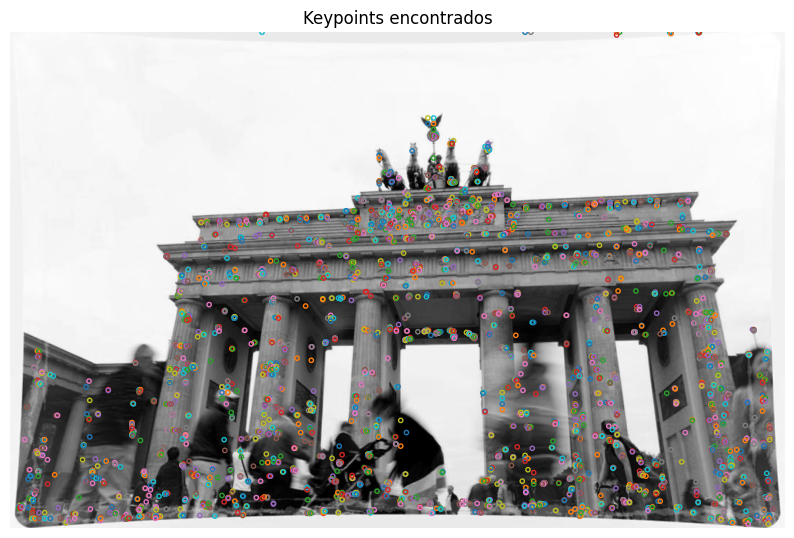

In [19]:
import cv2

def find_keypoints(dog_pyramid, threshold=0.074):
    keypoints = []
    
    for octave_index, octave in enumerate(dog_pyramid):
        for scale_index, (dog_level1, dog_level2) in enumerate(zip(octave[:-1], octave[1:])):
            # Encontrar los puntos clave usando el detector de esquinas Harris
            harris_response = cv2.cornerHarris(dog_level2, blockSize=5, ksize=3, k=0.03)
            
            # Filtrar los puntos clave por umbral
            keypoints_indices = np.argwhere(harris_response > threshold)
            
            # Agregar los puntos clave a la lista
            for keypoint_index in keypoints_indices:
                y, x = keypoint_index
                keypoints.append((x * (2 ** octave_index), y * (2 ** octave_index), scale_index + 1))
    
    return keypoints

# Encontrar puntos clave en la pirámide de DoG
keypoints = find_keypoints(dog_pyramid)
#print(keypoints)
print(f'Encontrados {len(keypoints)} puntos clave.')

import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

# Seleccionar una paleta de colores
cmap = get_cmap('tab10')

# Visualizar los puntos clave en la imagen original con colores diferentes
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(img, cmap='gray')

for i, (x, y, scale) in enumerate(keypoints):
    color = cmap(i % 10) 
    circle = plt.Circle((x, y), radius=3, color=color, fill=False)
    ax.add_patch(circle)

plt.title('Keypoints encontrados')
plt.axis('off')
plt.show()
